<a href="https://colab.research.google.com/github/KrishnaSChavan/MachineLearning/blob/main/Clav_Cell_segmentation_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation,MaxPool2D,Conv2DTranspose,Concatenate,Input,Dense
from tensorflow.keras.models import Model,Sequential
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications.resnet import ResNet50
import tensorflow_hub as hub
from keras.utils import to_categorical
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google. colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishnaschavan","key":"6f1c6fc054fb8d6259f3b6411ea6191e"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed

100% 6.40G/6.40G [05:26<00:00, 22.0MB/s]

In [ ]:
import zipfile
zip_r = zipfile.ZipFile('/content/cervical-cancer-largest-dataset-sipakmed.zip')
zip_r.extractall()
zip_r.close()

In [ ]:
one = "/content/im_Dyskeratotic/im_Dyskeratotic/"
two = "/content/im_Koilocytotic/im_Koilocytotic/"
three = "/content/im_Metaplastic/im_Metaplastic/"
four = "/content/im_Parabasal/im_Parabasal/CROPPED/"
five = "/content/im_Superficial-Intermediate/im_Superficial-Intermediate/"

In [ ]:
path = [one,two,three,four,five]

In [ ]:
data = []
labels = []
height = 64
width = 64
channels = 3
classes = 43
n_inputs = height * width * channels

i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            try:
                print(p+a)

                image=cv2.imread(p+a)


                image_from_array = Image.fromarray(image, 'RGB')

                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except:
                print('')
    i+=1

In [ ]:
len(data)

1645

In [ ]:
data = np.array(data)

In [ ]:
labels = np.array(labels)

In [ ]:
data.dtype,data.shape

(dtype('uint8'), (1645, 64, 64, 3))

# Mask

In [ ]:
def preprocess_image(image):

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    image_uint8 = cv2.convertScaleAbs(image_gray)


    ret, thresh1 = cv2.threshold(image_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    binary_image = np.expand_dims(thresh1, axis=-1)

    return binary_image

In [ ]:
mask = []

for image in data:
    binary_image = preprocess_image(image)
    mask.append(binary_image)

In [ ]:
mask = np.array(mask)

In [ ]:
data.dtype

dtype('uint8')

In [ ]:
mask.dtype

dtype('uint8')

In [ ]:
data.shape

(1645, 256, 256, 3)

In [ ]:
mask.shape

(1645, 256, 256, 1)

In [ ]:
data_three_channels = np.repeat(mask[1:5], 3, axis=-1)

In [ ]:
data_three_channels.shape

(4, 256, 256, 3)

In [ ]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

# U-Net

In [ ]:
def conv_block(inputs,num_filters):
    x = Conv2D(num_filters,3,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    x = Conv2D(num_filters,3,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def encoder(inputs,num_filters):
    x = conv_block(inputs,num_filters)
    p = MaxPool2D((2,2))(x)

    return x,p
def decoder(inputs,skip_features,num_filters):
    x = Conv2DTranspose(num_filters,(2,2),strides=2,padding='same')(inputs)
    x = Concatenate()([x,skip_features])
    x = conv_block(x,num_filters)

    return x

In [ ]:
def unet(input_shape):
    inputs = Input(input_shape)

    # encoders
    s0,p0 = encoder(inputs,32)
    s1,p1 = encoder(p0,64)   # p = 256
    s2,p2 = encoder(p1,128)      # p = 128
    s3,p3 = encoder(p2,256)      # p = 64
    s4,p4 = encoder(p3,512)      # p = 32

    # Bridge
    b1 = conv_block(p4,1024)

    #decoder

    d1 = decoder(b1,s4,512)      # p = 32
    d2 = decoder(d1,s3,256)      # p = 64
    d3 = decoder(d2,s2,128)      # p = 128
    d4 = decoder(d3,s1,64)       # p = 256
    d5 = decoder(d4,s0,32)

    #output

    outputs = Conv2D(3,(1,1),padding="same",activation = "sigmoid")(d5)

    model = Model(inputs,outputs,name='U-Net')

    return model

In [ ]:
input_shape = (256,256,3)
model = unet(input_shape=input_shape)

In [ ]:
np.random.seed(42)
s = np.arange(data.shape[0])
np.random.shuffle(s)
Data = data[s]
# Mask = mask[s]
Labels = labels[s]

In [ ]:
Mask_3 = np.repeat(Mask, 3, axis=-1)

In [ ]:
Mask_3.shape

(1645, 256, 256, 3)

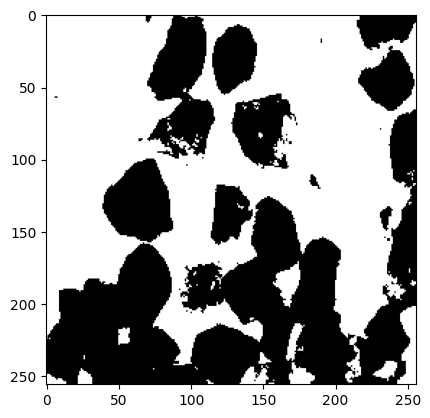

In [ ]:
plt.imshow(Mask_3[1])

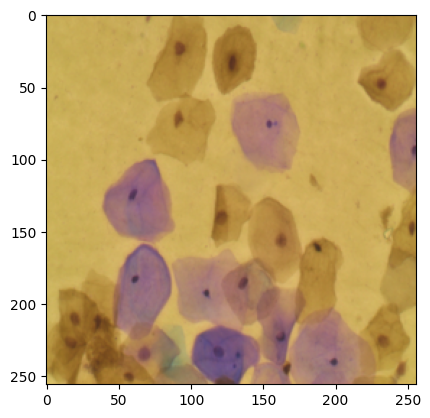

In [ ]:
plt.imshow(Data[1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Data, Mask_3, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1316, 256, 256, 3)
(329, 256, 256, 3)
(1316, 256, 256, 3)
(329, 256, 256, 3)


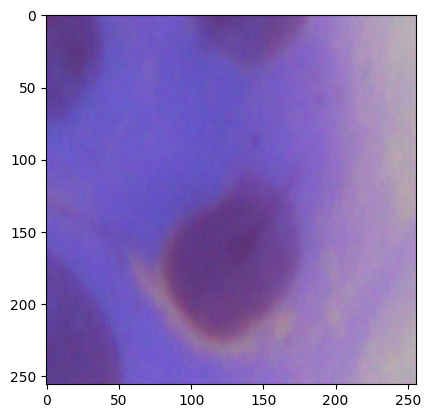

In [ ]:
plt.imshow(X_train[1])

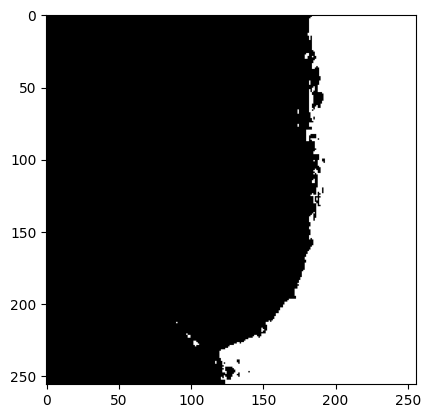

In [ ]:
plt.imshow(y_train[1])

In [ ]:
IMAGE_SHAPE = (256,256)
BATCH_SIZE = 32
data_gen = ImageDataGenerator(rescale=(1/255.))

train_data = data_gen.flow(
    x = X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_data = data_gen.flow(
    x = X_test,
    y=y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_1 = model.fit(
                train_data,
                epochs = 30,
                validation_data=test_data
)

Epoch 1/30
42/42 [==============================] - 59s 580ms/step - loss: 594.7586 - accuracy: 0.0895 - val_loss: 3196.6147 - val_accuracy: 1.0101e-04
Epoch 2/30
42/42 [==============================] - 20s 470ms/step - loss: 587.0850 - accuracy: 0.0258 - val_loss: 540.8218 - val_accuracy: 0.0045
Epoch 3/30
42/42 [==============================] - 19s 451ms/step - loss: 590.1539 - accuracy: 0.0188 - val_loss: 552.3850 - val_accuracy: 0.0220
Epoch 4/30
42/42 [==============================] - 20s 483ms/step - loss: 596.2339 - accuracy: 0.1749 - val_loss: 548.7516 - val_accuracy: 0.1275
Epoch 5/30
42/42 [==============================] - 20s 466ms/step - loss: 603.8686 - accuracy: 0.3139 - val_loss: 552.3792 - val_accuracy: 0.2841
Epoch 6/30
42/42 [==============================] - 20s 488ms/step - loss: 612.5084 - accuracy: 0.3061 - val_loss: 634.3864 - val_accuracy: 0.1725
Epoch 7/30
42/42 [==============================] - 20s 479ms/step - loss: 622.2985 - accuracy: 0.3001 - val_loss

In [ ]:
xyz = np.reshape(data[465],(data.shape[1],data.shape[2],data.shape[3]))

In [ ]:
pree = cv2.resize(xyz, (256, 256))

In [ ]:
image_from_array = Image.fromarray(xyz, 'RGB')
size_change = image_from_array.resize((256, 256))

In [ ]:
yelllow = np.array(size_change)

In [ ]:
yelllow.shape

(256, 256, 3)

In [ ]:
finall = np.reshape(yelllow,(-1,yelllow.shape[0],yelllow.shape[1],yelllow.shape[2]))

In [ ]:
finall.shape

(1, 256, 256, 3)

In [ ]:
my_pred = model.predict(np.reshape(data[53],(-1,data.shape[1],data.shape[2],data.shape[3]))/255.)

1/1 [==============================] - 1s 1s/step


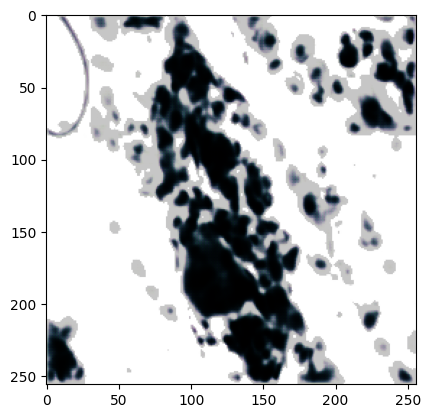

In [ ]:
plt.imshow(np.reshape(my_pred,(data.shape[1],data.shape[2],data.shape[3])))

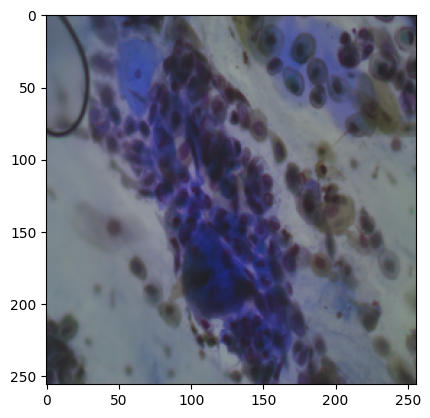

In [ ]:
plt.imshow(np.reshape(data[53],(data.shape[1],data.shape[2],data.shape[3]))/255.)

# Resnet

In [ ]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

In [ ]:
IMAGE_SHAPE = (256,256)
def create_model(model_url, num_classes=5):

    feature_extraction_layer = hub.KerasLayer(model_url, trainable=False, name="feature_extraction", input_shape=IMAGE_SHAPE+(3,))

    # create our own model
    model = Sequential()
    model.add(feature_extraction_layer)
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model

In [ ]:
resnet_model = create_model(resnet_url)

In [ ]:
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True
)


In [ ]:
one_hot_labels = to_categorical(Labels, num_classes=5)

In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(Data, labels, test_size = 0.2, random_state = 1)

print(X_train_r.shape)
print(X_test_r.shape)
print(y_train_r.shape)
print(y_test_r.shape)

(1316, 64, 64, 3)
(329, 64, 64, 3)
(1316,)
(329,)


In [ ]:
BATCH_SIZE = 32
data_gen = ImageDataGenerator(rescale=(1/255.))

train_data = data_gen.flow(
    x = X_train_r,
    y=y_train_r,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_data = data_gen.flow(
    x = X_test_r,
    y=y_test_r,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
resnet_history = resnet_model.fit(
    train_data,
    validation_data=test_data,
    epochs=10
)

Epoch 1/10
42/42 [==============================] - 26s 532ms/step - loss: 0.7442 - accuracy: 0.7188 - val_loss: 0.4202 - val_accuracy: 0.8480
Epoch 2/10
42/42 [==============================] - 19s 459ms/step - loss: 0.3252 - accuracy: 0.8967 - val_loss: 0.3473 - val_accuracy: 0.8693
Epoch 3/10
42/42 [==============================] - 19s 463ms/step - loss: 0.2589 - accuracy: 0.9225 - val_loss: 0.3124 - val_accuracy: 0.8875
Epoch 4/10
42/42 [==============================] - 19s 454ms/step - loss: 0.2152 - accuracy: 0.9362 - val_loss: 0.2878 - val_accuracy: 0.8967
Epoch 5/10
42/42 [==============================] - 19s 463ms/step - loss: 0.1845 - accuracy: 0.9468 - val_loss: 0.2848 - val_accuracy: 0.8967
Epoch 6/10
42/42 [==============================] - 19s 456ms/step - loss: 0.1652 - accuracy: 0.9514 - val_loss: 0.2719 - val_accuracy: 0.9027
Epoch 7/10
42/42 [==============================] - 19s 462ms/step - loss: 0.1455 - accuracy: 0.9567 - val_loss: 0.2667 - val_accuracy: 0.9027

In [ ]:
classifier_pred = resnet_model.predict(np.reshape(data[53], (-1, data.shape[1], data.shape[2], data.shape[3])))

1/1 [==============================] - 1s 870ms/step


In [ ]:
np.argmax(classifier_pred)

2

In [ ]:
def pred(image):
    x = np.argmax(resnet_model.predict(np.reshape(image, (-1, image.shape[0], image.shape[1], image.shape[2]))))
    plt.imshow(np.reshape(image,(image.shape[0],image.shape[1],image.shape[2]))/255.)
    plt.show()
    y = model.predict(np.reshape(image,(-1,image.shape[0],image.shape[1],image.shape[2]))/255.)
    print(categories[x])
    plt.imshow(np.reshape(y,(image.shape[0],image.shape[1],image.shape[2])))
    plt.show()


1/1 [==============================] - 0s 24ms/step


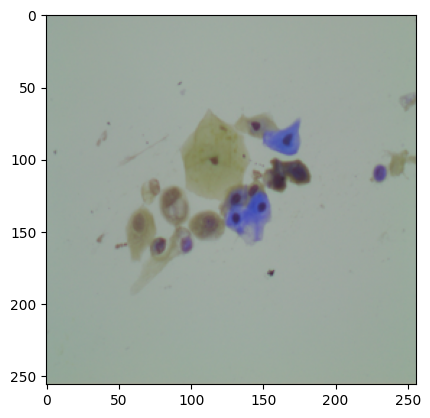

1/1 [==============================] - 0s 25ms/step
Metaplastic


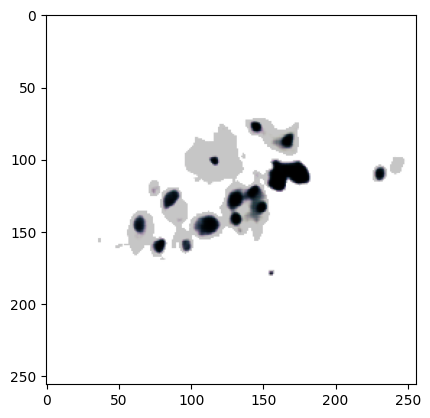

In [ ]:
pred(data[45])

In [ ]:
X_train_r[1].reshape((-1,3)).shape


(4096, 3)

In [ ]:
cer_test = []
for xyz in X_test_r:
    i = xyz.reshape((-1,3))
    cer_test.append(np.array(i))
cer_test = np.array(cer_test)

X_test_svm = []
for xyz in cer_test:
    aaa = xyz.reshape(-1)
    X_test_svm.append(np.array(aaa))

cerv_test = np.array(X_test_svm)

In [ ]:
def transform_data(X_test_r):
    cer_test = []
    for xyz in X_test_r:
        i = xyz.reshape((-1, 3))
        cer_test.append(np.array(i))
    cer_test = np.array(cer_test)

    a_test_svm = []
    for xyz in cer_test:
        aaa = xyz.reshape(-1)
        a_test_svm.append(np.array(aaa))

    cerv_test = np.array(a_test_svm)

    return cerv_test

X_train_svm = transform_data(X_train_r)
X_test_svm = transform_data(X_test_r)

In [ ]:
X_train_svm  = X_train_svm /255.
X_test_svm = X_test_svm /255.

In [ ]:
svm = SVC()
svm.fit(X_train_svm,y_train_r)

SVC()

In [ ]:
y_pred_svm = svm.predict(X_test_svm)

In [ ]:
svm_scale = SVC()
svm_scale.fit(X_train_svm,y_train_r)

SVC()

In [ ]:
y_pred_svm_2 = svm.predict(X_test_svm)

In [ ]:
print("Classification Report: \n", classification_report(y_test_r, y_pred_svm))

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        55
           3       0.48      1.00      0.65       157
           4       0.00      0.00      0.00        25

    accuracy                           0.48       329
   macro avg       0.10      0.20      0.13       329
weighted avg       0.23      0.48      0.31       329



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train_svm.max()

1.0

In [ ]:
X_train_svm.shape

(1316, 196608)

In [ ]:
64*64*3

12288

In [ ]:
256*256*3

196608

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_svm, y_train_r)

KNeighborsClassifier()

In [ ]:
y_pred = knn.predict(X_test_svm)

In [ ]:
print("Classification Report: \n", classification_report(y_test_r, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.10      0.10      0.10        42
           1       0.15      0.10      0.12        50
           2       0.17      0.05      0.08        55
           3       0.48      0.70      0.57       157
           4       0.12      0.04      0.06        25

    accuracy                           0.37       329
   macro avg       0.20      0.20      0.19       329
weighted avg       0.30      0.37      0.32       329



In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_svm, y_train_r)
y_pred_random = rf_classifier.predict(X_test_svm)

In [ ]:
print("Classification Report: \n", classification_report(y_test_r, y_pred_random))

Classification Report: 
               precision    recall  f1-score   support

           0       0.25      0.02      0.04        42
           1       0.20      0.04      0.07        50
           2       0.13      0.04      0.06        55
           3       0.48      0.91      0.63       157
           4       0.00      0.00      0.00        25

    accuracy                           0.45       329
   macro avg       0.21      0.20      0.16       329
weighted avg       0.31      0.45      0.32       329



In [ ]:
scaled_data = data/255.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_data, labels, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1316, 64, 64, 3)
(329, 64, 64, 3)
(1316,)
(329,)


In [ ]:
cer = []
for xyz in X_train:
    i = xyz.reshape((-1,3))
    cer.append(np.array(i))

In [ ]:
cer = np.array(cer)

In [ ]:
cerv = []
for xyz in cer:
    aaa = xyz.reshape(-1)
    cerv.append(np.array(aaa))

In [ ]:
cerv = np.array(cerv)

In [ ]:

cer_test = []
for xyz in X_test:
    i = xyz.reshape((-1,3))
    cer_test.append(np.array(i))
cer_test = np.array(cer_test)

cerv_test = []
for xyz in cer_test:
    aaa = xyz.reshape(-1)
    cerv_test.append(np.array(aaa))

cerv_test = np.array(cerv_test)

In [ ]:
svm = SVC()
svm.fit(cerv, y_train)
y_svm = svm.predict(cerv_test)

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_svm)

In [ ]:
acc

0.8115501519756839

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_svm))

Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.74      0.78        42
           1       0.47      0.78      0.59        50
           2       0.78      0.69      0.73        55
           3       1.00      1.00      1.00       157
           4       1.00      0.08      0.15        25

    accuracy                           0.81       329
   macro avg       0.81      0.66      0.65       329
weighted avg       0.86      0.81      0.80       329



In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(cerv, y_train)
y_pred = knn.predict(cerv_test)

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.51      0.60      0.55        42
           1       0.60      0.12      0.20        50
           2       0.57      0.15      0.23        55
           3       0.62      1.00      0.77       157
           4       0.67      0.08      0.14        25

    accuracy                           0.60       329
   macro avg       0.59      0.39      0.38       329
weighted avg       0.60      0.60      0.52       329



In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(cerv, y_train)
y_pred_random = rf_classifier.predict(cerv_test)

In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.51      0.60      0.55        42
           1       0.60      0.12      0.20        50
           2       0.57      0.15      0.23        55
           3       0.62      1.00      0.77       157
           4       0.67      0.08      0.14        25

    accuracy                           0.60       329
   macro avg       0.59      0.39      0.38       329
weighted avg       0.60      0.60      0.52       329



In [ ]:
acc = accuracy_score(y_test, y_pred)

In [ ]:
acc

0.601823708206687